In [1]:
# Import libraries

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

#pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [2]:
# Import Visual Growth CSV file

df_growth_relationship_original = pd.read_csv('../data/derived/combined_data_by_year.csv')
df_growth = df_growth_relationship_original.copy()

df_growth.head()

,Unnamed: 0,year,country_id,country_txt_wb,country_txt_gtd,country_code,region,region_txt,arrivals,population,...,nkill_total,nkillus_total,nkillte_total,nwound_total,nwoundus_total,nwoundte_total,nvictim_total,nvictimus_total,nvictimte_total,incident_ct_total
0,0,2012,5,Albania,NaN,ALB,NaN,NaN,3156000,2900401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,2012,6,Algeria,Algeria,DZA,10.0,Middle East & North Africa,2634000,37383887,...,25.0,0.0,2.0,76.0,0.0,0.0,101.0,0.0,2.0,27
2,2,2012,7,Andorra,NaN,AND,NaN,NaN,2238000,82427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,2012,8,Angola,NaN,AGO,NaN,NaN,528000,25107931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,2012,10,Antigua and Barbuda,NaN,ATG,NaN,NaN,247000,90409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# Manipulate data for visualization

df_growth = df_growth.rename(columns={"year": "year_gtd"})

cols_keep = ['year_gtd', 'country_id', 'country_txt_wb', 'tourism_rank_2012', 'tourism_group', 
             'incident_ct_total']
df_growth = df_growth[cols_keep]


# Calculate an "increase/decrease" of incidents using 2012 as baseline
# (Calculate as count in relation to 2012 value)

#Create df of 2012 baseline values and join to original dataframe to use for count change

df_baseline_2012 = df_growth[df_growth['year_gtd'] == 2012]
df_baseline_2012 = df_baseline_2012[['year_gtd', 'country_txt_wb', 'incident_ct_total']]

df_growth = df_growth.merge(df_baseline_2012, left_on=['country_txt_wb'], 
                    right_on = ['country_txt_wb'], how='left')

df_growth = df_growth.rename(columns={"year_gtd_x": "year_gtd", 
                    "incident_ct_total_x": "incident_ct_total", 
                    "incident_ct_total_y": "2012_incident_ct_total"})
df_growth = df_growth[['year_gtd', 'country_id', 'country_txt_wb', 'tourism_rank_2012', 
                    'tourism_group', 'incident_ct_total', '2012_incident_ct_total']]

# Calculate count increase/decrease

df_growth['incident_change'] = df_growth['incident_ct_total'] - df_growth['2012_incident_ct_total']

# Retain needed columns

df_growth = df_growth[['year_gtd', 'country_id', 'country_txt_wb', 'tourism_rank_2012', 'tourism_group', 
             'incident_ct_total', 'incident_change']]

#df_growth[(df_growth['tourism_group'] =='low') | (df_growth['tourism_group'] =='high')]
df_growth.head()

,year_gtd,country_id,country_txt_wb,tourism_rank_2012,tourism_group,incident_ct_total,incident_change
0,2012,5,Albania,57,NaN,0,0
1,2012,6,Algeria,65,NaN,27,0
2,2012,7,Andorra,73,NaN,0,0
3,2012,8,Angola,113,NaN,0,0
4,2012,10,Antigua and Barbuda,127,NaN,0,0


In [4]:
# Create High and Low Tourism dfs
# and pivot to wide format for plotting

df_high_long = df_growth[df_growth['tourism_group'] == 'high']
df_high_long['incident_change'] = df_high_long['incident_change'].fillna(0)
n_high = len(df_high_long)
df_high = df_high_long.pivot(index ='year_gtd', columns ='country_txt_wb', values ='incident_change') 

df_low_long = df_growth[df_growth['tourism_group'] == 'low']
df_low_long['incident_change'] = df_low_long['incident_change'].fillna(0)
n_low = len(df_low_long)
df_low = df_low_long.pivot(index ='year_gtd', columns ='country_txt_wb', values ='incident_change') 

df_all_long = df_growth
df_all_long['incident_change'] = df_all_long['incident_change'].fillna(0)
n_all = len(df_all_long)
df_all = df_all_long.pivot(index ='year_gtd', columns ='country_txt_wb', values ='incident_change') 

# Add Median column to each dataframe

df_high['median'] = df_high.median(numeric_only=True, axis=1)
df_low['median'] = df_low.median(numeric_only=True, axis=1)
df_all['median'] = df_all.median(numeric_only=True, axis=1)

# Add Quartile to each dataframe

high_columns_std = list(df_high.columns)
del high_columns_std[-1]
df_high['25th'] = df_high[high_columns_std].quantile(.25, axis=1)
df_high['75th'] = df_high[high_columns_std].quantile(.75, axis=1)

low_columns_std = list(df_low.columns)
del low_columns_std[-1]
df_low['25th'] = df_low[low_columns_std].quantile(.25, axis=1)
df_low['75th'] = df_low[low_columns_std].quantile(.75, axis=1)

all_columns_std = list(df_all.columns)
del all_columns_std[-1]
df_all['25th'] = df_all[all_columns_std].quantile(.25, axis=1)
df_all['75th'] = df_all[all_columns_std].quantile(.75, axis=1)

df_high = df_high.reset_index() 
df_low = df_low.reset_index() 
df_all = df_all.reset_index() 

#df_high
#df_low
df_all

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


country_txt_wb,year_gtd,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uzbekistan,Vanuatu,Vietnam,Virgin Islands (U.S.),West Bank and Gaza,Zambia,Zimbabwe,median,25th,75th
0,2012,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.00
1,2013,0,-13,0,0,0,1,0,0,1,...,0,0,0,0,13,0,2,0.0,0.0,1.00
2,2014,2,-21,0,0,0,0,0,7,0,...,0,0,0,0,43,0,1,0.0,0.0,2.00
3,2015,0,-19,0,0,0,-1,1,11,0,...,0,0,0,0,96,0,0,0.0,0.0,1.75
4,2016,1,-23,0,0,0,1,2,9,3,...,0,0,0,0,40,0,0,0.0,0.0,2.00
5,2017,1,-21,0,2,0,2,0,2,1,...,0,0,1,0,21,1,3,0.0,0.0,2.00
6,2018,0,-24,0,0,0,1,0,3,1,...,0,0,1,0,24,0,1,0.0,0.0,1.00


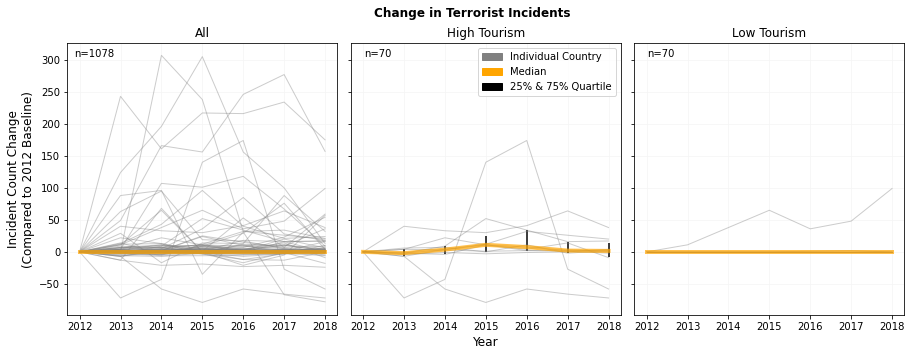

In [5]:
# Create Growth visualization

# Set figure

fig, (ax3, ax1, ax2) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
fig.subplots_adjust(wspace=.05, hspace=0)
fig.suptitle('Change in Terrorist Incidents', fontsize=12, fontweight ="bold")

# Create plots

for column in df_high.drop(['year_gtd', '25th', '75th'], axis=1):
    ax1.plot(df_high['year_gtd'], df_high[column], marker='', color='grey', linewidth=1, alpha=0.4)
ax1.plot(df_high['year_gtd'], df_high['median'], marker='', color='orange', linewidth=4, alpha=0.7)
ax1.vlines(df_high['year_gtd'], df_high['25th'], df_high['75th'], colors ="black")
ax1.set_title('High Tourism')
ax1.grid(which='major', axis='both', c='whitesmoke')
ax1.set_xticks(np.arange(min(df_high['year_gtd']), max(df_high['year_gtd'])+1, 1.0))

for column in df_low.drop(['year_gtd', '25th', '75th'], axis=1):
    ax2.plot(df_low['year_gtd'], df_low[column], marker='', color='grey', linewidth=1, alpha=0.4)
ax2.plot(df_low['year_gtd'], df_low['median'], marker='', color='orange', linewidth=4, alpha=0.7)
ax2.vlines(df_low['year_gtd'], df_low['25th'], df_low['75th'], colors ="black")
ax2.set_title('Low Tourism')
ax2.grid(which='major', axis='both', c='whitesmoke')
ax2.set_xticks(np.arange(min(df_low['year_gtd']), max(df_low['year_gtd'])+1, 1.0))

for column in df_all.drop(['year_gtd', '25th', '75th'], axis=1):
    ax3.plot(df_all['year_gtd'], df_all[column], marker='', color='grey', linewidth=1, alpha=0.4)
ax3.plot(df_all['year_gtd'], df_all['median'], marker='', color='orange', linewidth=4, alpha=0.7)
ax3.vlines(df_all['year_gtd'], df_all['25th'], df_all['75th'], colors ="black")
ax3.set_title('All')
ax3.grid(which='major', axis='both', c='whitesmoke')
ax3.set_xticks(np.arange(min(df_all['year_gtd']), max(df_all['year_gtd'])+1, 1.0))

# Add Annotations

ax1.annotate('n=%.0f' % n_high, 
        xy=(0.1, 0.1), xycoords='axes fraction', xytext=(0.1, 0.95),
        textcoords='axes fraction', horizontalalignment='center', fontsize=10)
ax2.annotate('n=%.0f' % n_low, 
        xy=(0.1, 0.1), xycoords='axes fraction', xytext=(0.1, 0.95),
        textcoords='axes fraction', horizontalalignment='center', fontsize=10)
ax3.annotate('n=%.0f' % n_all, 
        xy=(0.1, 0.1), xycoords='axes fraction', xytext=(0.1, 0.95),
        textcoords='axes fraction', horizontalalignment='center', fontsize=10)

# Add figure legend

average = mpatches.Patch(color='orange', label='Median')
country = mpatches.Patch(color='grey', label='Individual Country')
std_dev = mpatches.Patch(color='black', label='25% & 75% Quartile')
ax1.legend(handles=[country, average, std_dev], loc='best')

# Add Axis Labels

ax1.set_xlabel('Year', fontsize=12)

ax3.set_ylabel('Incident Count Change\n(Compared to 2012 Baseline)', fontsize=12)
#ax3.set_ylim(ymin=-2, ymax=2)

plt.show()